<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Quadrotor Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Quadrotor Problem:* The goal is to move the quadrotor from a given initial position and orientation to a given final position and orientation in minimum total time.                    
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)
4. [Remarks](#rem)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/quadrotorP2P_JMP.jl")
nh = 60
QuadrotorJMP = quadrotorP2P_JMP(;nh=nh);

set_optimizer(QuadrotorJMP,Ipopt.Optimizer)
set_attribute(QuadrotorJMP, "print_level", 5)
set_optimizer_attribute(QuadrotorJMP,"tol",1e-8)
set_optimizer_attribute(QuadrotorJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(QuadrotorJMP,"max_iter",1000)
set_optimizer_attribute(QuadrotorJMP,"mu_strategy","adaptive")
set_attribute(QuadrotorJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(QuadrotorJMP, "linear_solver", "ma57")
set_optimizer_attribute(QuadrotorJMP, "print_timing_statistics", "yes")
#set_attribute(QuadrotorJMP, "sb", "yes") # to not print Ipopt's banner

In [3]:
println("Solving...")
optimize!(QuadrotorJMP)
println()

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    22424
Number of nonzeros in inequality constraint Jacobian.:      482
Number of nonzeros in Lagrangian Hessian.............:  1622237

Total number of variables............................:      611
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      183
                     variables with only upper bounds:        0
Total number of equality constraints.................:      374
Total number of inequali

In [4]:
# Display results
if termination_status(QuadrotorJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(QuadrotorJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(QuadrotorJMP) == MOI.TIME_LIMIT && has_values(QuadrotorJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(QuadrotorJMP))
println()

  (Local) solution found
  objective value = 0.7075539135449358



In [5]:
#state
p1 = QuadrotorJMP[:p1];
p2 = QuadrotorJMP[:p2];
p3 = QuadrotorJMP[:p3];
v1 = QuadrotorJMP[:v1];
v2 = QuadrotorJMP[:v2];
v3 = QuadrotorJMP[:v3];
#control 
at = QuadrotorJMP[:at];
ϕ = QuadrotorJMP[:ϕ];
θ = QuadrotorJMP[:θ];
ψ = QuadrotorJMP[:ψ];

#co-state
con_p1 = QuadrotorJMP[:d_p1];
con_p2 = QuadrotorJMP[:d_p2];
con_p3 = QuadrotorJMP[:d_p3];
con_v1 = QuadrotorJMP[:d_v1];
con_v2 = QuadrotorJMP[:d_v2];
con_v3 = QuadrotorJMP[:d_v3];

tf = value(QuadrotorJMP[:tf])
Δtt = value.(tf)/nh
t = Vector((0:nh)*Δtt); 

p = - [[ dual(con_p1[i]), dual(con_p2[i]), dual(con_p3[i]), dual(con_v1[i]), dual(con_v2[i]), dual(con_v3[i]) ] for i in 1:nh] ;
p = costateInterpolation(p, t);

p1 = Vector(value.(p1))
p2 = Vector(value.(p2))
p3 = Vector(value.(p3))
v1 = Vector(value.(v1))
v2 = Vector(value.(v2))
v3 = Vector(value.(v3))

at = Vector(value.(at))
ϕ = Vector(value.(ϕ))
θ = Vector(value.(θ))
ψ = Vector(value.(ψ))

u = [ [ at[i], ϕ[i], θ[i], ψ[i] ] for i in 1:nh+1] ;

x =  [ [ p1[i], p2[i], p3[i], v1[i], v2[i], v3[i] ] for i in 1:nh+1] ;


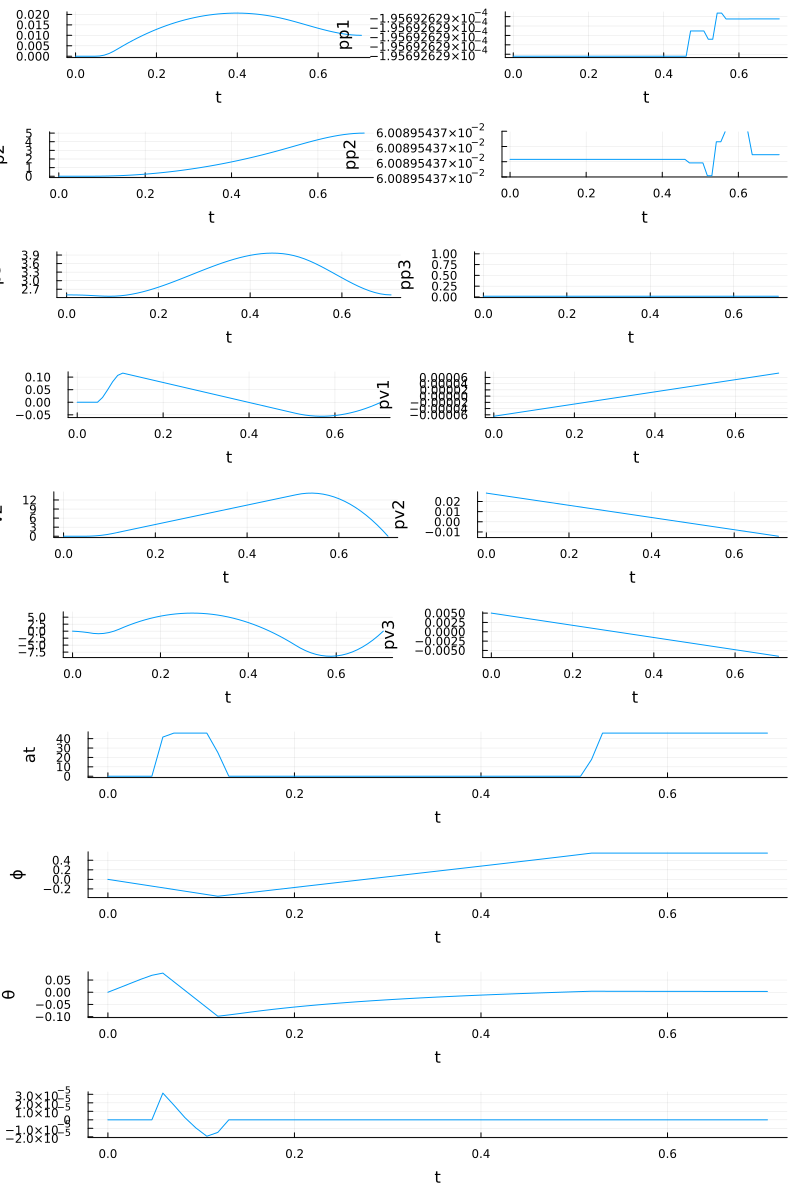

In [6]:
using Plots

p1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false)
p2_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p2", legend = false)
p3_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p3", legend = false)
v1_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "v1", legend = false)
v2_plot = plot(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "v2", legend = false)
v3_plot = plot(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "v3", legend = false)
pp1_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp1", legend = false)
pp2_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp2", legend = false)
pp3_plot = plot(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp3", legend = false)
pv1_plot = plot(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv1", legend = false)
pv2_plot = plot(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv2", legend = false)
pv3_plot = plot(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv3", legend = false)
u1_plot = plot(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "at", legend = false)
u2_plot = plot(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "ϕ", legend = false)
u3_plot = plot(t, [ u[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "θ", legend = false)
u4_plot = plot(t, [ u[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ψ", legend = false)

layout = @layout [a b; c d; e f; g h; i j; k l; m; n; o ;p]
ploting = plot(p1_plot, pp1_plot, p2_plot, pp2_plot, p3_plot, pp3_plot, v1_plot, pv1_plot, v2_plot, pv2_plot, v3_plot, pv3_plot, u1_plot, u2_plot, u3_plot, u4_plot, layout = layout)
ploting = plot!(ploting, size = (800, 1200))
display(ploting)

GKS: Possible loss of precision in routine SET_WINDOW


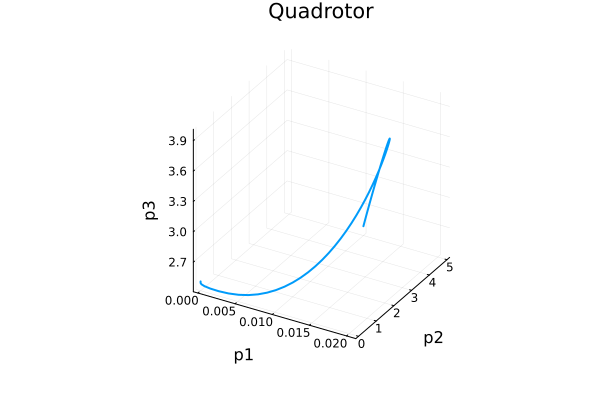

In [7]:
plot(
    p1,
    p2,
    p3;
    linewidth = 2,
    legend = nothing,
    title = "Quadrotor",
    xlabel = "p1",
    ylabel = "p2",
    zlabel = "p3",
)

##### Animation of the quadrotor trajectory 

┌ Info: Saved animation to C:\Users\hajje\AppData\Local\Temp\jl_xSj8fsrUbu.gif
└ @ Plots C:\Users\hajje\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\hajje\\AppData\\Local\\Temp\\jl_xSj8fsrUbu.gif")
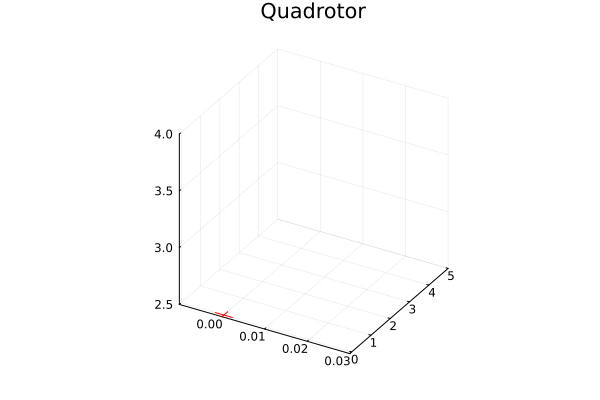

In [8]:
function get_wing_positions(ϕ, θ, ψ)
    arm_length = 0.2

    # Rotation matrix based on Euler angles (ϕ, θ, ψ)
    cr = cos(ϕ)
    sr = sin(ϕ)
    cp = cos(θ)
    sp = sin(θ)
    cy = cos(ψ)
    sy = sin(ψ)
    R=  [(cy*cp)    (cy*sp*sr - sy*cr) (cy*sp*cr + sy*sr);
        (sy*cp)     (sy*sp*sr + cy*cr) (sy*sp*cr - cy*sr);
        (-sp)       (cp*sr)            (cp*cr)]

    # Quadrotor arms in local frame
    arm1 = arm_length * R * [1, 0, 0]
    arm2 = arm_length * R * [0, 1, 0]
    return arm1/100, arm2
end
plt1 = plot3d(1; xlim = (-0.01, 0.03), ylim = (-0.1, 5), zlim = (2.5, 4), title = "Quadrotor", legend=false)
@gif for i = 1:nh+1
    wing1,wing2 = get_wing_positions(ϕ[i], θ[i], ψ[i])
    # Draw arms
    pltw1 = plot(plt1, [p1[i]-wing1[1], p1[i]+wing1[1]], [p2[i]-wing1[2], p2[i]+wing1[2]], [p3[i]-wing1[3], p3[i]+wing1[3]], color=:red)
    pltw2 = plot!( [p1[i]-wing2[1], p1[i]+wing2[1]], [p2[i]-wing2[2], p2[i]+wing2[2]], [p3[i]-wing2[3], p3[i]+wing2[3]], color=:red)
    push!(plt1, p1[i], p2[i], p3[i])
end every nh ÷ min(nh, 100)

┌ Info: Saved animation to C:\Users\hajje\AppData\Local\Temp\jl_ZWHELwBGlM.gif
└ @ Plots C:\Users\hajje\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\hajje\\AppData\\Local\\Temp\\jl_ZWHELwBGlM.gif")
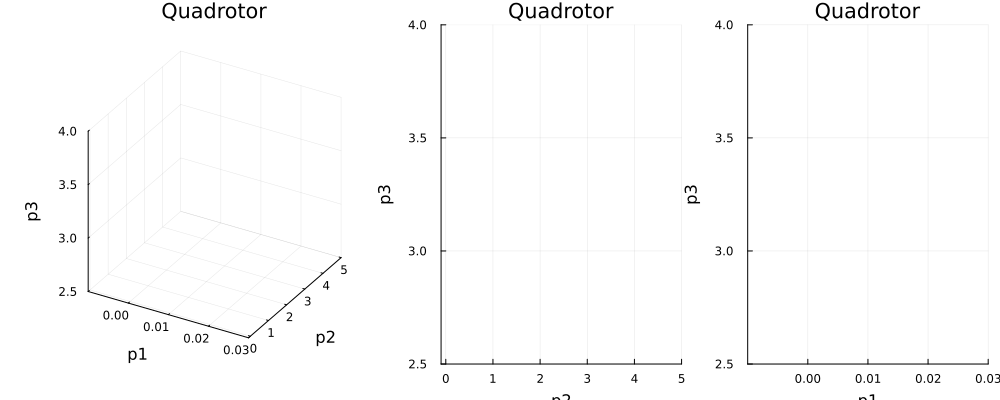

In [9]:
l = @layout [a{0.4w} b c]
plt1 = plot3d(1; xlim = (-0.01, 0.03), ylim = (-0.1, 5), zlim = (2.5, 4), legend=false, xlabel = "p1", ylabel = "p2", zlabel = "p3")
plt2 = plot(1; xlim = (-0.1, 5), ylim = (2.5, 4), legend=false, xlabel = "p2", ylabel = "p3")
plt3 = plot(1; xlim = (-0.01, 0.03), ylim = (2.5, 4), legend=false, xlabel = "p1", ylabel = "p3")

combined_plot = plot(plt1, plt2,plt3, layout=l, title = "Quadrotor", size = (1000, 400))

# Create GIF animation
@gif for i = 1:nh+1
    push!(plt1, p1[i], p2[i], p3[i])
    push!(plt2, p2[i], p3[i])
    push!(plt3, p1[i], p3[i])

    combined_plot = plot(plt1, plt2, plt3, layout=l, title = "Quadrotor", size = (1000, 400))
end every nh ÷ min(nh, 100)

## 2. Solving with OptimalControl <a id='oc'></a>

In [10]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/quadrotorP2P_OC.jl")
QuadrotorOC = quadrotorP2P_OC();

In [11]:
init = (state = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],control = [10, 0.0, 0.0, 0.0],);

In [22]:
import HSL_jll
# Solve the problem
sol = OptimalControl.solve(QuadrotorOC,init=init, grid_size=100,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path, print_timing_statistics="yes")

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     6715
Number of nonzeros in inequality constraint Jacobian.:      202
Number of nonzeros in Lagrangian Hessian.............:     1919

Total number of variables............................:     1314
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      505
                     variables with only upper bounds:        0
Total number of equality constraints.................:      915
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 5.00e+00 5.05e-09   0.0 0.00e

CTBase.OptimalControlSolution

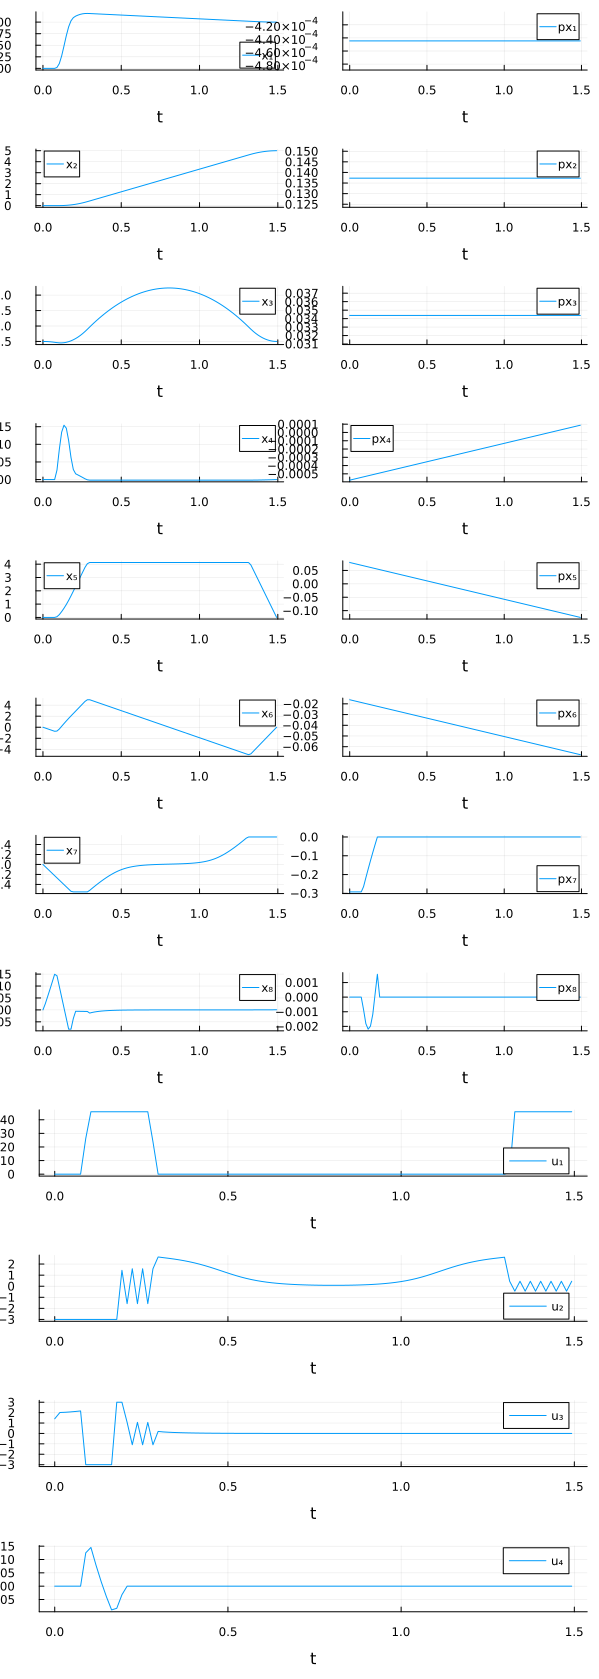

In [23]:
plot(sol)

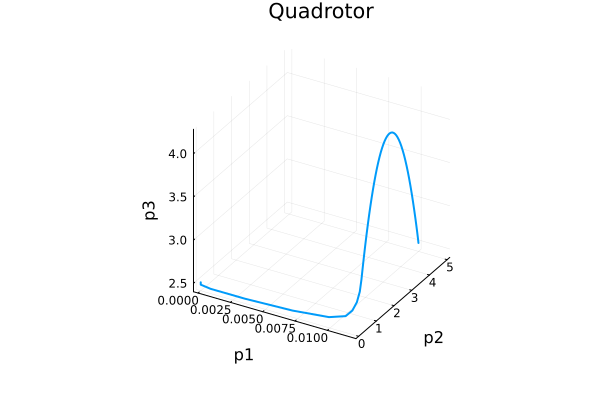

In [24]:
using JuMP
t_f = sol.variable
Δt = ones(nh)*(t_f/(nh))
ts = cumsum([0; value.(Δt)])[1:end]
x = [sol.state(t) for t in ts]
p1 = [x[i][1] for i in 1:length(x)]
p2 = [x[i][2] for i in 1:length(x)]
p3 = [x[i][3] for i in 1:length(x)]
plot(
    p1,
    p2,
    p3;
    linewidth = 2,
    legend = nothing,
    title = "Quadrotor",
    xlabel = "p1",
    ylabel = "p2",
    zlabel = "p3",
)

┌ Info: Saved animation to C:\Users\hajje\AppData\Local\Temp\jl_zQZsjC1CZi.gif
└ @ Plots C:\Users\hajje\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\hajje\\AppData\\Local\\Temp\\jl_zQZsjC1CZi.gif")
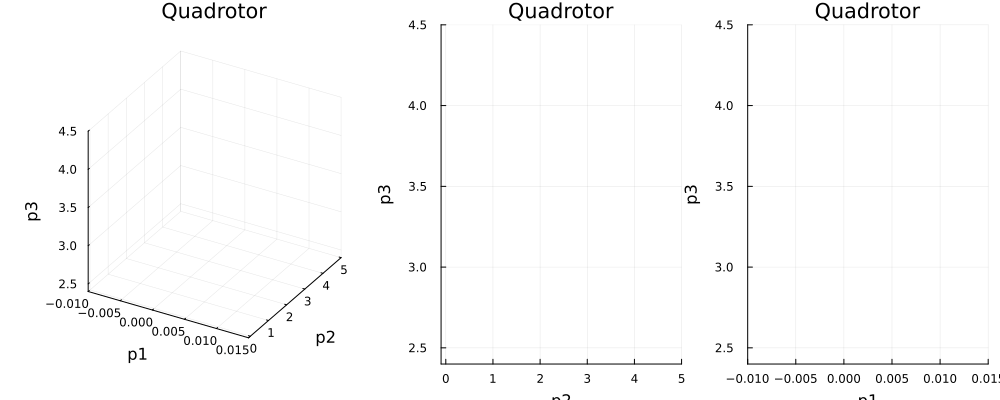

In [25]:
l = @layout [a{0.4w} b c]
plt1 = plot3d(1; xlim = (-0.01, 0.015), ylim = (-0.1, 5), zlim = (2.4, 4.5), legend=false, xlabel = "p1", ylabel = "p2", zlabel = "p3")
plt2 = plot(1; xlim = (-0.1, 5), ylim = (2.4, 4.5), legend=false, xlabel = "p2", ylabel = "p3")
plt3 = plot(1; xlim = (-0.01, 0.015), ylim = (2.4, 4.5), legend=false, xlabel = "p1", ylabel = "p3")

combined_plot = plot(plt1, plt2,plt3, layout=l, title = "Quadrotor", size = (1000, 400))

# Create GIF animation
@gif for i = 1:length(x)
    push!(plt1, p1[i], p2[i], p3[i])
    push!(plt2, p2[i], p3[i])
    push!(plt3, p1[i], p3[i])

    combined_plot = plot(plt1, plt2, plt3, layout=l, title = "Quadrotor", size = (1000, 400))
end every length(x) ÷ min(length(x), 100)

## 3. Comparison <a id='comp'></a>

In [26]:
tf = value(QuadrotorJMP[:tf])

0.7071053275075742

In [27]:
sol.variable

1.492395709932903

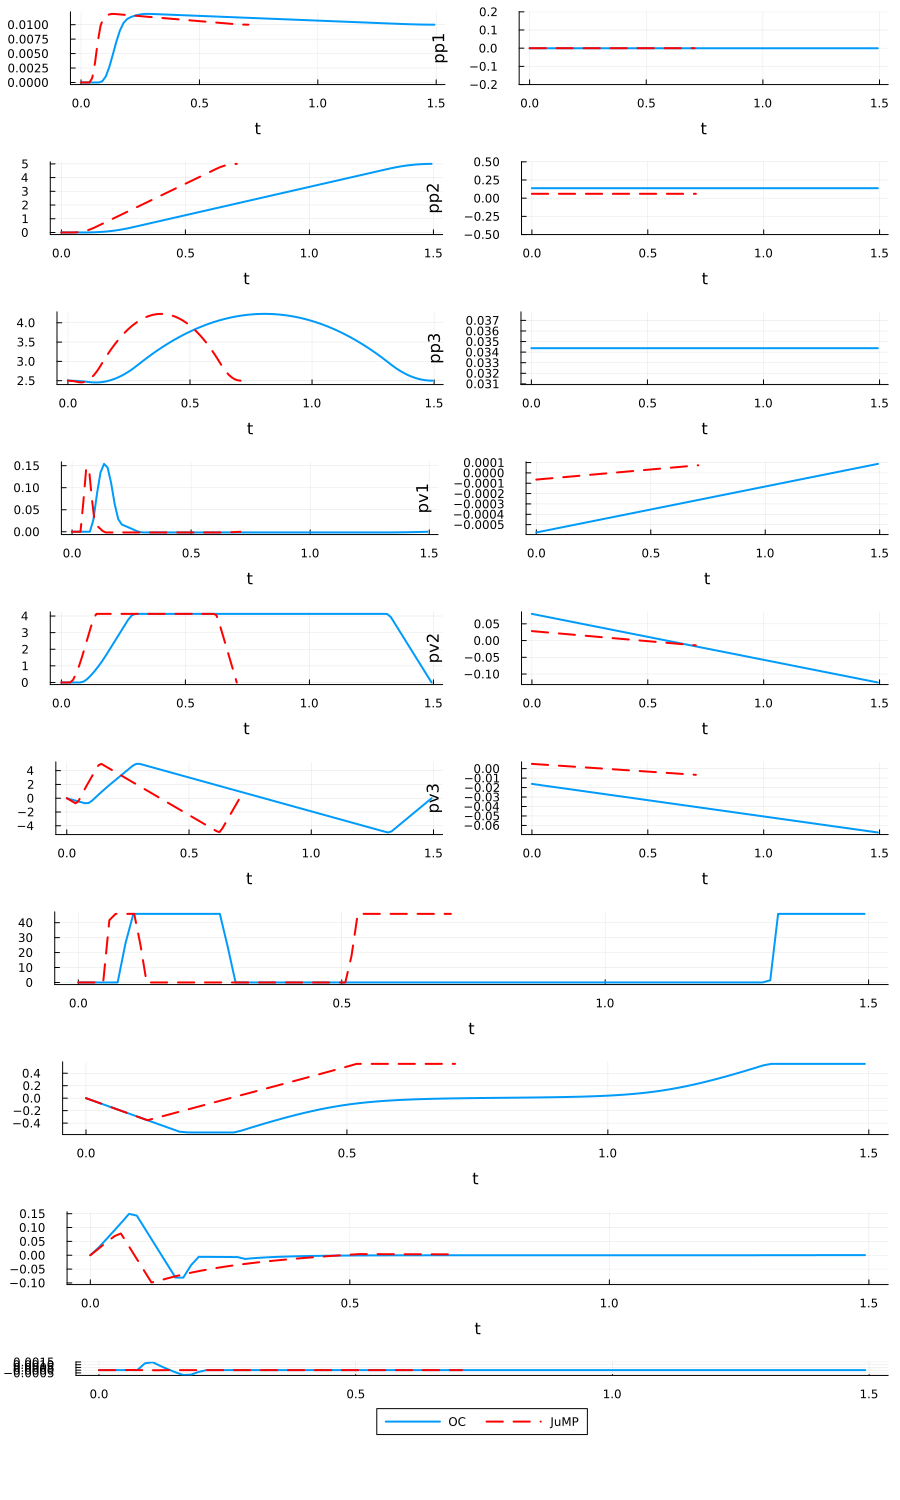

In [28]:
using Plots
p_p1 = plot(plot(sol)[1],line = 2)
p_p1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false,line = 2, color = "red",linestyle=:dash)

p_p2 = plot(plot(sol)[2],line = 2)
p_p2 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p2", legend = false,line = 2, color = "red",linestyle=:dash)

p_p3 = plot(plot(sol)[3],line = 2)
p_p3 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p3", legend = false,line = 2, color = "red",linestyle=:dash)

p_v1 = plot(plot(sol)[4],line = 2)
p_v1 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "v1", legend = false,line = 2, color = "red",linestyle=:dash)

p_v2 = plot(plot(sol)[5],line = 2)
p_v2 = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "v2", legend = false,line = 2, color = "red",linestyle=:dash)

p_v3 = plot(plot(sol)[6],line = 2)
p_v3 = plot!(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "v3", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp1 = plot(plot(sol)[9],line = 2, ylim = (-0.2,0.2))
p_pp1 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp1", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp2 = plot(plot(sol)[10],line = 2, ylim = (-0.5,0.5))
p_pp2 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp2", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp3 = plot(plot(sol)[11],line = 2)
p_pp3 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "pp3", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp4 = plot(plot(sol)[12],line = 2)
p_pp4 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv1", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp5 = plot(plot(sol)[13],line = 2)
p_pp5 = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv2", legend = false,line = 2, color = "red",linestyle=:dash)

p_pp6 = plot(plot(sol)[14],line = 2)
p_pp6 = plot!(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "pv3", legend = false,line = 2, color = "red",linestyle=:dash)

p_at = plot(plot(sol)[17],line = 2)
p_at = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "at", legend = false,line = 2, color = "red",linestyle=:dash)

p_ϕ = plot(plot(sol)[7],line = 2)
p_ϕ = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "ϕ", legend = false,line = 2, color = "red",linestyle=:dash)

p_θ = plot(plot(sol)[8],line = 2)
p_θ = plot!(t, [ u[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "θ", legend = false,line = 2, color = "red",linestyle=:dash)

p_ψ = plot(plot(sol)[20], label ="OC",line = 2)
p_ψ = plot!(t, [ u[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "ψ", legend = false,label = "JuMP",line = 2, color = "red",linestyle=:dash)
p_ψ = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [p_p1 p_pp1; p_p2 p_pp2; p_p3 p_pp3; p_v1 p_pp4; p_v2 p_pp5; p_v3 p_pp6; p_at; p_ϕ; p_θ; p_ψ]

x_plot = plot(p_p1, p_pp1, p_p2, p_pp2, p_p3, p_pp3, p_v1, p_pp4, p_v2, p_pp5, p_v3, p_pp6, p_at, p_ϕ, p_θ, p_ψ, layout = layout)
x_plot = plot!(size = (900, 1500))

display(x_plot)

## 4. Remarks <a id='rem'></a>

* tf isn't the same for `OptimalControl`and `JuMP`.
* The issue could be due to the way we derivate ϕ and θ.
* The solvers face some issues when solving the problem with a number of discretization points greater than 60.
* The initial guess concerns only the control parameter `at`, with `OptimalControl` we can't set only one initial guess for the control parameter.

## 5. Set Initial Guess

In [29]:
function get_x0_ipopt(model)
     optimizer = Ipopt.Optimizer()
     MOI.copy_to(optimizer, model)
     primal_start = optimizer.variable_primal_start
     n_var = length(primal_start)
     x0 = zeros(n_var)
     for i in eachindex(x0)
         if isnothing(primal_start[i])
             lb = optimizer.variables.lower[i]
             ub = optimizer.variables.upper[i]
             x0[i] = clamp(0.0, lb, ub)
         else
             x0[i] = primal_start[i]
         end
     end
     return x0
end


get_x0_ipopt (generic function with 1 method)

In [30]:
[ x for x in get_x0_ipopt(QuadrotorJMP) if (x != 0.0 && x!=10) ]


Float64[]

In [31]:
docp = direct_transcription(QuadrotorOC)
nlp = get_nlp(docp)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ReverseDiffADGradient,
  ReverseDiffADHvprod,
  ForwardDiffADJprod,
  ReverseDiffADJtprod,
  SparseADJacobian,
  SparseReverseADHessian,
  ForwardDiffADGHjvprod,
}
  Problem name: Generic
   All variables: ████████████████████ 1314   All constraints: ████████████████████ 1016  
            free: █████████████⋅⋅⋅⋅⋅⋅⋅ 808               free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: █⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 1                lower: ██⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 101   
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ████████⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 505            low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ███████████████████⋅ 915   
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: ( 99.78% sparsity)   1919            linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
        